<a href="https://colab.research.google.com/github/seacatgm/-/blob/main/Classification/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F%20%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0%20%D0%BF%D0%BE%20%D0%B0%D0%B2%D1%82%D0%BE%D1%80%D1%83/classification_text%2C_writers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, Adadelta

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R '/content/texts' # проверяем есть ли папка texts, если есть удаляем

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
!unzip -q '/content/drive/My Drive/neuro/base/Тексты писателей.zip' -d '/content/texts'  # загружаем тексты писателей в папку texts

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r') # Задаем открытие нужного файла в режиме чтения
  text = f.read() # Читаем файл
  text = text.replace('\n', ' ') # Переносы строки заменяем пробелами
  return text

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Задаем названия классов, авторы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты
trainText = [] # Здесь будут обучающие тексты
testText = [] # Здесь будут проверочные тексты

for i in className: # Проходим по каждому классу
  for j in os.listdir('texts/'): # Проходим по каждому файлу в папке с текстами
    if i in j: # Проверяем, содержит ли файл j в названии имя класса i
      if 'Обучающая' in j: # Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) # Добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') # Выводим print если добавилась
      if 'Тестовая' in j: # Если в имени найденного класса есть строка "Тестовая" 
        testText.append(readText('texts/' + j)) # Добавляем в тестовую выборку 
        print(j, 'добавлен в тестовую выборку') # Выводим print если добавилась
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Формирование обучающей выборки по листу индексов слов
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 
  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаемся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step):# Функция принимает последовательность индексов, размер окна, шаг окна
  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []  # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна 
  for wI in wordIndexes: # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6

  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # Берем очередной текст вида "кол-во окон в тексте*длину окна
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса
  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в сеть
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в сеть

  return (xSamples, ySamples)

In [ ]:
maxWordsCount = 20000 # задаем лимит по количеству слов, берем 20 000 самых часто встречающихся 
# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов 

xLen = 10000 # задаем размер окна
step = 1000 # задаем шаг

trainWordIdx = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIdx = tokenizer.texts_to_sequences(testText) # Поверочные тесты в индексы

xTrain, yTrain = createSetsMultiClasses(trainWordIdx, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIdx, xLen, step) # извлекаем поверочную выборку

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words


Epoch 1/30
14/14 [==============================] - 4s 269ms/step - loss: 0.3229 - accuracy: 0.8978 - val_loss: 0.2959 - val_accuracy: 0.9536
Epoch 2/30
14/14 [==============================] - 4s 260ms/step - loss: 2.5201e-04 - accuracy: 1.0000 - val_loss: 0.2182 - val_accuracy: 0.9628
Epoch 3/30
14/14 [==============================] - 4s 262ms/step - loss: 5.2239e-05 - accuracy: 1.0000 - val_loss: 0.2083 - val_accuracy: 0.9613
Epoch 4/30
14/14 [==============================] - 4s 263ms/step - loss: 3.9293e-05 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.9644
Epoch 5/30
14/14 [==============================] - 4s 263ms/step - loss: 3.4220e-05 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9659
Epoch 6/30
14/14 [==============================] - 4s 264ms/step - loss: 2.6952e-05 - accuracy: 1.0000 - val_loss: 0.1877 - val_accuracy: 0.9659
Epoch 7/30
14/14 [==============================] - 4s 263ms/step - loss: 2.3607e-05 - accuracy: 1.0000 - val_loss: 0.1818 - val

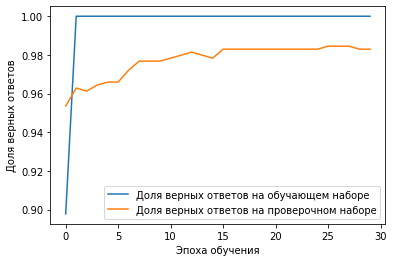

In [ ]:
# Создаем сеть
model01 = Sequential()

model01.add(Dense(1000, input_dim=maxWordsCount, activation="relu"))

model01.add(Dropout(0.25))

model01.add(Dense(200, activation="linear"))

model01.add(Dropout(0.1))

model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer=Adam(lr = 0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=30,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()